# Are later-built high-speed-rail less meaningful? 
### Using DID to analyze the effect of China’s high-speed rails on urban development

---

- Github link: 

- Word count: 1953

- Operating Environment: Docker-based CASA Computing Environment

- Full runtime: 17 seconds

In [44]:
# Import all required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy import stats
from IPython.display import Image, display

In [2]:
# Hiding warnings makes output cleaner
import warnings
warnings.filterwarnings('ignore')

---

## 1 Introduction

China's high-speed-rail (HSR) network has expanded rapidly over the past decade. According to the National Railway Administration of China (https://www.nra.gov.cn), since the opening of the first high-speed-rail in 2008, the Beijing-Tianjin Intercity Railway, China has surpassed 40,000 kilometers in total length of high-speed-rail by 2021. 

In earlier years, people believed that HSR had greatly boosted economic development. However, in recent years, doubts have emerged on the Internet regarding the significance of some newly built HSR projects, particularly their economic benefits. Since newly constructed high-speed railways are often situated in economically underdeveloped provinces, especially in some non-plain areas, it is believed that their construction costs are excessively high and their economic promotional impact is limited. 

This study aims to examine whether these newly built high-speed railways indeed yield lower economic promotion effects.

## 2 Literature review

There are a lot of studies on China's HSR. Initial studies focused on the impact of high-speed rail opening on different socio-economic indicators of the city. The most common indicators are GDP, GDP by industry, and GDP per capita. Some studies have developed new indicators and evaluated the impact of high-speed rail on them. For example, the study on the impact of high-speed rail on urban expansion (Deng et al., 2020), mainly used the Differences-in-Differences (DID) method and confirmed that high-speed rail will lead to greater urban expansion.

PSM (Propensity Score Matching) combined with DID can better perform this type of analysis. This method has been used to study urban specialization patterns (Lin, 2017), income distribution (Jin et al., 2022), and urban innovation (Fan and Xu, 2023).

In addition to innovations at the indicator level, some studies also focus on the promotion effect of high-speed rail in different regions and at different opening times. A comparative study of developed and underdeveloped regions shows that HSR has a more significant positive impact on underdeveloped areas with better basic conditions. (Liang et al., 2020). There are also analyses of the regional heterogeneity of the impact of HSR using a wider range of data combined with panel regression (Ke et al., 2017).

## 3 Research question

The research question is: Among China’s high-speed rail lines, do newer lines have weaker positive effects on the cities they pass through than those of earlier-built lines?

It should be made clear that, "newer" does not refer to time, but refers to those high-speed rail lines that were built later due to poor location or high cost. Some short connecting lines newly built in developed areas do not fall into this category.

## 4 Presentation of data

### 4.1 Data introduction

The data used in the study is panel data for Chinese prefecture-level cities from 1990 to 2021, compiled based on the China Statistical Yearbook (https://www.stats.gov.cn/sj/ndsj). The dataset was sourced from an online data store (http://www.gis5g.com/data/tjnj?id=267), and comprises over 100 indicators for more than 300 prefecture-level cities.

### 4.2 Data filtering

#### 4.2.1 Data filtering approach

The study will first use DID to analyze the impact of two HSR lines in different periods and regions, and then compared the two groups of impacts. Therefore, we need to carefully select two appropriate treatment and control groups.

The two selected HSR lines should meet the following requirements:
1. They pass through two distant regions and are opened at a long interval.
2. When the selected line is opened, there should be as few nearby HSR lines as possible to ensure the independence of their impact.
3. The line lengths should be similar to ensure that the coverage of the lines is similar.

As shown in the figure, two lines were selected: the Beijing-Shanghai HSR (opened in June 2011) and the Changsha-Kunming HSR (opened in December 2016). In particular, Shandong Province and Guizhou Province were selected to ensure that the cities in each DID analysis are from the same province.

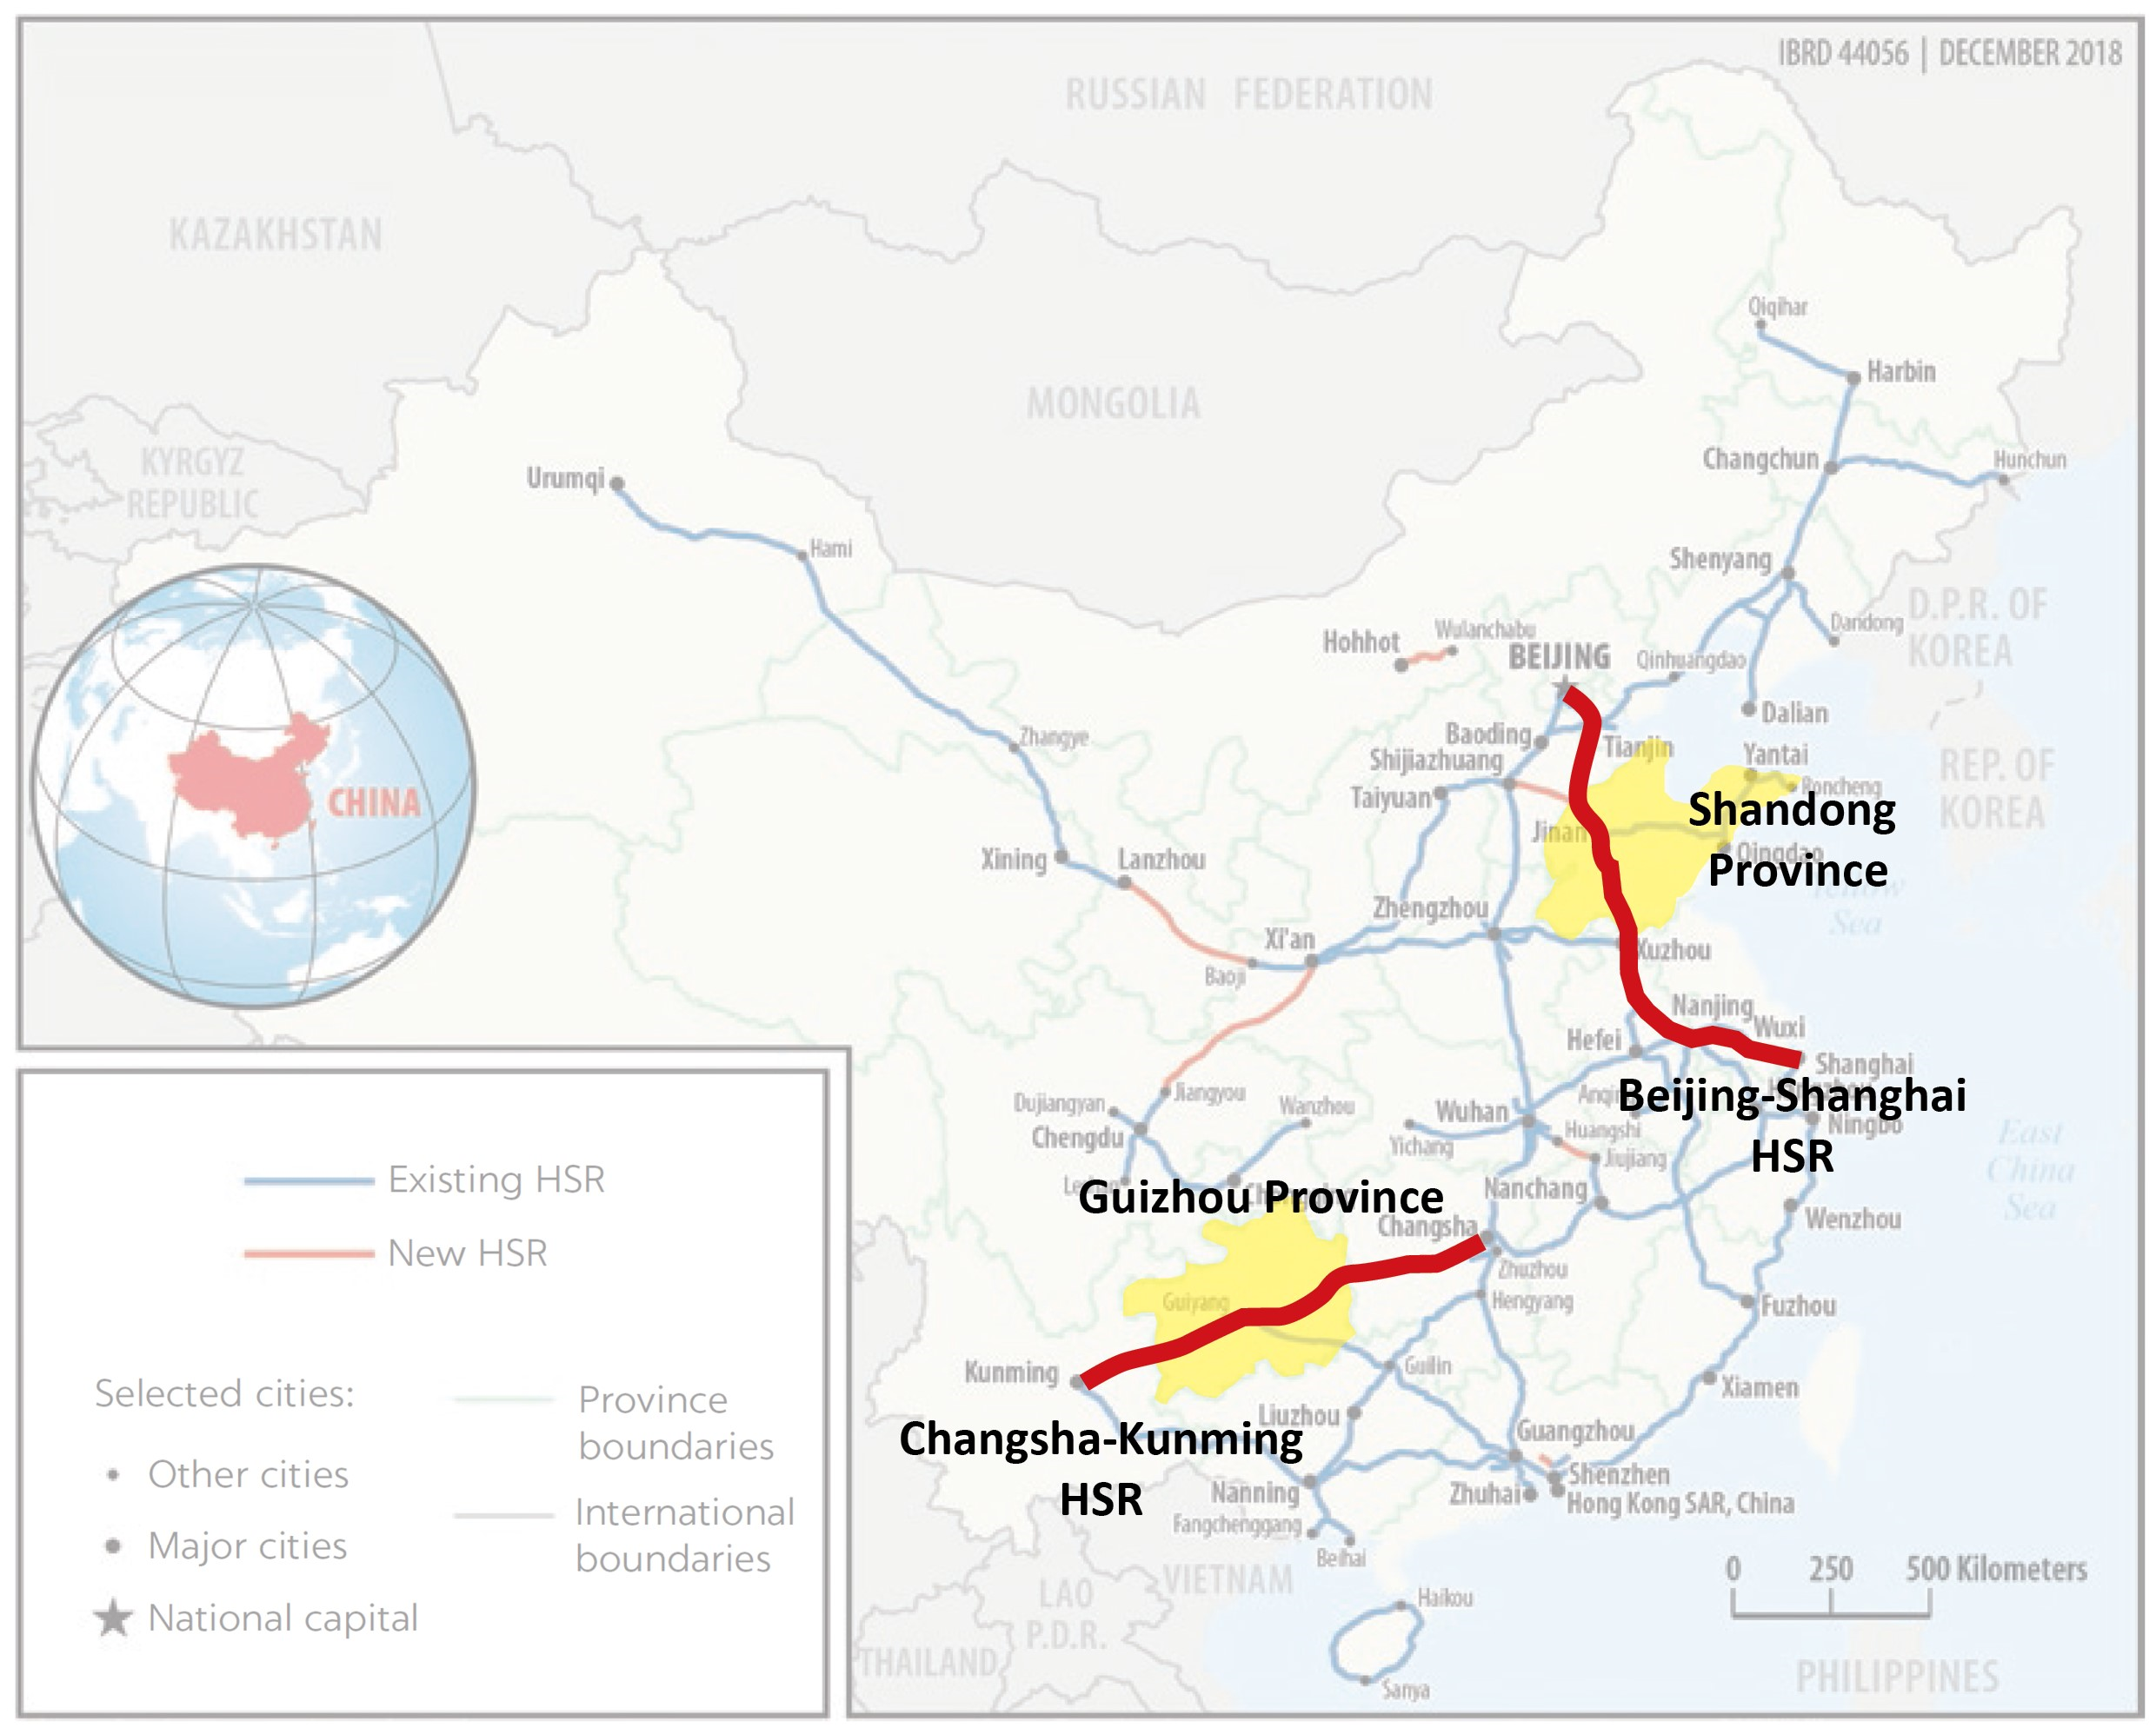

In [43]:
display(Image(filename='data/chinaHSR.png'))

Basemap source: https://en.wikipedia.org/wiki/High-speed_rail_in_China

For each province (DID group), The following conditions should be met when selecting cities:
1. The administrative levels of the cities in the treatment and control group are same.
2. The city center of the treatment group has a HSR station, and the city center of the control group is far away enough from the station.
3. The geographical conditions of the cities in the treatment and control group are similar.

As shown in the figure, in the two provinces, red is the treatment group and yellow is the control group. The remaining cities are not included in the analysis for the following reasons:

1. Among the cities in Shandong Province, Jinan and Qingdao are sub-provincial cities, which are different from other prefecture-level cities. The distance between Jining and the HSR line is vague that its impact cannot be clearly defined. The remaining cities are too far away from the  treatment group and are all coastal cities, with large geographical differences.

![Shandong Province](data/shandong.jpg)
Basemap source: https://datav.aliyun.com/portal/school/atlas/area_selector

2. Among the cities in Guizhou Province, Guiyang is a sub-provincial city, and a HSR has been connected to Guangzhou from Guiyang since 2014. The three autonomous prefectures in the south are also different from ordinary prefecture-level cities.

![Shandong Province](data/guizhou.jpg)
Basemap source: https://datav.aliyun.com/portal/school/atlas/area_selector

Thus, we obtained the list of cities for the two DID analysis.

In [3]:
cities_shandong_treatment = ['Dezhou', 'Taian', 'Zaozhuang']
cities_shandong_control = ['Liaocheng', 'Heze', 'Binzhou', 'Zibo', 'Linyi']
cities_guizhou_treatment = ['Anshun', 'Tongren']
cities_guizhou_control = ['Zunyi', 'Bijie', 'Liupanshui']

print('Shandong Province treatment group:', cities_shandong_treatment)
print('Shandong Province control group:', cities_shandong_control)
print('Guizhou Province treatment group:', cities_guizhou_treatment)
print('Guizhou Province control group:', cities_guizhou_control)

Shandong Province treatment group: ['Dezhou', 'Taian', 'Zaozhuang']
Shandong Province control group: ['Liaocheng', 'Heze', 'Binzhou', 'Zibo', 'Linyi']
Guizhou Province treatment group: ['Anshun', 'Tongren']
Guizhou Province control group: ['Zunyi', 'Bijie', 'Liupanshui']


Then, we select the time span. When dividing the impact, the impact of high-speed rail lines opened on or after July 1 is generally counted as the following year, while those opened before July 1 are counted as the current year (Chi and Han, 2023). 

The Pre-Treatment Period is selected to be longer for better evaluation of trends. The cutoff time of the Post-Treatment Period depends on important events. For the Beijing-Shanghai HSR, other HSR lines opened in Shandong Province in 2016, which will bring new impacts. For the Changsha-Kunming HSR, the dataset is up to 2021. In 2020-2021, the COVID-19 may have a complex impact on GDP data, and we will further consider whether to adjust the cutoff point to 2019 in our analysis.

In [4]:
years = list(range(2001, 2022))
years_shandong_pre = list(range(2001, 2011))
years_shandong_post = list(range(2011, 2016))
years_guizhou_pre = list(range(2007, 2017))
years_guizhou_post = list(range(2017, 2022))

print('Shandong Province Pre-Treatment Period:', years_shandong_pre)
print('Shandong Province Post-Treatment Period:', years_shandong_post)
print('Guizhou Province Pre-Treatment Period:', years_guizhou_pre)
print('Guizhou Province Post-Treatment Period:', years_guizhou_post)

Shandong Province Pre-Treatment Period: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Shandong Province Post-Treatment Period: [2011, 2012, 2013, 2014, 2015]
Guizhou Province Pre-Treatment Period: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Guizhou Province Post-Treatment Period: [2017, 2018, 2019, 2020, 2021]


Finally, we need to select the indicator columns to be used for measuring impact or for PSM analysis. GDP, GDP by industry, GDP per capita, and real estate-related data are usually used to measure impact (Liang et al., 2020). Some of these indicators require secondary calculations.

In [5]:
# Filter the columns of the original data
indicator_columns = ['GDP', 'primary_GDP', 'secondary_GDP', 'tertiary_GDP', 'real_estate', 
                     'population', 'population_re']

indicator = {
    # GDP data (for measuring impact)
    'GDP': 'Gross Regional Product (10k CNY)',
    'primary_GDP': 'Primary Industry Value Added (10k CNY)',
    'secondary_GDP': 'Secondary Industry Value Added (10k CNY)',
    'tertiary_GDP': 'Tertiary Industry Value Added (10k CNY)',

    # Real estate investment (for measuring impact)
    'real_estate': 'Real Estate Development Investment (10k CNY)',

    # Population (for calculating per capita indicators)
    'population': 'Average annual population (10,000)',
    'population_re': 'Registered population (10,000)'
}

df_indicator = pd.DataFrame(list(indicator.items()), columns=['Indicator', 'Description'])
df_indicator

Indicator                                   Description
0            GDP              Gross Regional Product (10k CNY)
1    primary_GDP        Primary Industry Value Added (10k CNY)
2  secondary_GDP      Secondary Industry Value Added (10k CNY)
3   tertiary_GDP       Tertiary Industry Value Added (10k CNY)
4    real_estate  Real Estate Development Investment (10k CNY)
5     population            Average annual population (10,000)
6  population_re                Registered population (10,000)

#### 4.2.2 Data filtering code

The dataset can be imported and filtered using the following code. 

However, since all the city names and column names in the dataset are in Chinese, the code for the filtering process contains a large number of Chinese characters. We directly provide the filtered dataset in 4.2.3.

##### (Hide and Skip)

In [6]:
# # Import original data
# original_data = pd.read_csv('data/Panel data of Chinese cities_1990_2021.csv', encoding='GBK')
# original_data.columns

In [7]:
# # List of city names
# cities = ['德州', '泰安', '枣庄', '聊城', '菏泽', '滨州', '淄博', '临沂', '安顺', '铜仁', '遵义', '毕节', '六盘水', ]

# # List of years, from 2001 to 2021
# years = list(range(2001, 2022))

# # List of indicators
# indicators = ['年份', '地区', 
#               '地区生产总值(万元)', '第一产业增加值(万元)', '第二产业增加值(万元)', '第三产业增加值(万元)', '房地产开发投资完成额(万元)', 
#               '年平均人口(万人)', '户籍人口(万人)']

# print("Cities:", cities)
# print("Years:", years)
# print("Indicators:", indicators)

In [8]:
# # Filter required data
# filtered_data_cn = original_data.loc[(original_data['地区'].isin(cities)) & (original_data['年份'].isin(years)), indicators]
# filtered_data_cn

In [9]:
# # Translate
# column_mapping = {
#     '年份': 'year',
#     '地区': 'city',
#     '地区生产总值(万元)': 'GDP',
#     '第一产业增加值(万元)': 'primary_GDP',
#     '第二产业增加值(万元)': 'secondary_GDP',
#     '第三产业增加值(万元)': 'tertiary_GDP',
#     '房地产开发投资完成额(万元)': 'real_estate',
#     '年平均人口(万人)': 'population',
#     '户籍人口(万人)': 'population_re'
# }

# city_mapping = {
#     '德州': 'Dezhou',
#     '泰安': 'Taian',
#     '枣庄': 'Zaozhuang',
#     '聊城': 'Liaocheng',
#     '菏泽': 'Heze',
#     '滨州': 'Binzhou',
#     '淄博': 'Zibo',
#     '临沂': 'Linyi',
#     '安顺': 'Anshun',
#     '铜仁': 'Tongren',
#     '遵义': 'Zunyi',
#     '毕节': 'Bijie',
#     '六盘水': 'Liupanshui'
# }

# filtered_data = filtered_data_cn.copy()
# filtered_data['地区'] = filtered_data['地区'].map(city_mapping)
# filtered_data = filtered_data.rename(columns=column_mapping)
# filtered_data.reset_index(drop=True, inplace=True)
# filtered_data

In [10]:
# # Save the data
# filtered_data.to_csv('data/filtered_data.csv', index=False, encoding='utf-8-sig')

#### 4.2.3 Data filtering result

In [11]:
# Import filtered data
filtered_data = pd.read_csv('data/filtered_data.csv')
filtered_data

year     city       GDP  primary_GDP  secondary_GDP  tertiary_GDP  \
0    2021     Zibo  42010000  1810631.000   2.073194e+07  1.947164e+07   
1    2020     Zibo  36730000  1568371.000   1.776997e+07  1.739166e+07   
2    2019     Zibo  36420000  1489578.000   1.818086e+07  1.674956e+07   
3    2018     Zibo  50683500  1459684.800   2.640104e+07  2.282785e+07   
4    2017     Zibo  47713600  1484296.110   2.477763e+07  2.114241e+07   
..    ...      ...       ...          ...            ...           ...   
268  2005  Tongren   2073252   601142.214   5.802114e+05  8.918959e+05   
269  2004  Tongren   1822602   528854.093   5.103967e+05  7.833478e+05   
270  2003  Tongren   1571952   456565.972   4.405820e+05  6.747997e+05   
271  2002  Tongren   1321301   384277.851   3.707674e+05  5.662516e+05   
272  2001  Tongren   1070651   311989.729   3.009527e+05  4.577034e+05   

     real_estate  population  population_re  
0        3742557       433.8         434.00  
1        3441747       433.9         434.00  
2        3133055       434.0         434.00  
3        2694898       434.0         434.00  
4        2418498       433.0         433.00  
..           ...         ...            ...  
268       365059       305.7         268.46  
269       324747       285.8         242.00  
270       284435       266.0         215.55  
271       244123       246.2         189.09  
272       203811       226.4         162.63  

[273 rows x 9 columns]

### 4.3 Data processing

First, calculate some new indicators.

In [12]:
new_indicator_columns = ['GDP_pc', 'secondary_GDP_pc', 'tertiary_GDP_pc']

new_indicator = {
    # GDP data (for measuring impact)
    'GDP_pc': 'GDP per capita',
    'secondary_GDP_pc': 'Per capita GDP of secondary industry',
    'tertiary_GDP_pc': 'Per capita GDP of tertiary industry',
}

In [13]:
# GDP per capita
filtered_data['GDP_pc'] = filtered_data['GDP'] / filtered_data['population']

# Per capita GDP of secondary industry
filtered_data['secondary_GDP_pc'] = filtered_data['secondary_GDP'] / filtered_data['population']

# Per capita GDP of tertiary industry
filtered_data['tertiary_GDP_pc'] = filtered_data['tertiary_GDP'] / filtered_data['population']

filtered_data

year     city       GDP  primary_GDP  secondary_GDP  tertiary_GDP  \
0    2021     Zibo  42010000  1810631.000   2.073194e+07  1.947164e+07   
1    2020     Zibo  36730000  1568371.000   1.776997e+07  1.739166e+07   
2    2019     Zibo  36420000  1489578.000   1.818086e+07  1.674956e+07   
3    2018     Zibo  50683500  1459684.800   2.640104e+07  2.282785e+07   
4    2017     Zibo  47713600  1484296.110   2.477763e+07  2.114241e+07   
..    ...      ...       ...          ...            ...           ...   
268  2005  Tongren   2073252   601142.214   5.802114e+05  8.918959e+05   
269  2004  Tongren   1822602   528854.093   5.103967e+05  7.833478e+05   
270  2003  Tongren   1571952   456565.972   4.405820e+05  6.747997e+05   
271  2002  Tongren   1321301   384277.851   3.707674e+05  5.662516e+05   
272  2001  Tongren   1070651   311989.729   3.009527e+05  4.577034e+05   

     real_estate  population  population_re         GDP_pc  secondary_GDP_pc  \
0        3742557       433.8         434.00   96841.862609      47791.459198   
1        3441747       433.9         434.00   84650.841208      40954.076976   
2        3133055       434.0         434.00   83917.050691      41891.391705   
3        2694898       434.0         434.00  116782.258065      60831.878226   
4        2418498       433.0         433.00  110193.071594      57223.168176   
..           ...         ...            ...            ...               ...   
268       365059       305.7         268.46    6781.982336       1897.976369   
269       324747       285.8         242.00    6377.193842       1785.852715   
270       284435       266.0         215.55    5909.593985       1656.323447   
271       244123       246.2         189.09    5366.779041       1505.960065   
272       203811       226.4         162.63    4729.023852       1329.296369   

     tertiary_GDP_pc  
0       44886.203320  
1       40082.173312  
2       38593.451613  
3       52598.729032  
4       48827.728060  
..               ...  
268      2917.552902  
269      2740.895024  
270      2536.840880  
271      2299.965678  
272      2021.658242  

[273 rows x 12 columns]

In [14]:
# Add new indicators to existing indicators
indicator_columns = indicator_columns + new_indicator_columns

indicator.update(new_indicator)

df_indicator = pd.DataFrame(list(indicator.items()), columns=['Indicator', 'Description'])
df_indicator

Indicator                                   Description
0               GDP              Gross Regional Product (10k CNY)
1       primary_GDP        Primary Industry Value Added (10k CNY)
2     secondary_GDP      Secondary Industry Value Added (10k CNY)
3      tertiary_GDP       Tertiary Industry Value Added (10k CNY)
4       real_estate  Real Estate Development Investment (10k CNY)
5        population            Average annual population (10,000)
6     population_re                Registered population (10,000)
7            GDP_pc                                GDP per capita
8  secondary_GDP_pc          Per capita GDP of secondary industry
9   tertiary_GDP_pc           Per capita GDP of tertiary industry

Now that we have all the indicators, we need to check the indicators to avoid data errors and take logarithms if necessary.

In [15]:
# Define a function to check the indicator trend
def plot_indicators(data, city_name, indicators, nrows, ncols):

    # Filter data for selected cities
    city_data = data[data['city'] == city_name]

    plt.style.use('seaborn-darkgrid')

    # Creating graphs and subgraphs by layout
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows), sharex=True)
    axes = axes.flatten()  # Flatten axes array for easy iteration

    # Traverse all indicators and draw a line chart for each
    for ax, ind in zip(axes, indicators):
        ax.plot(city_data['year'], city_data[ind], marker='o', label=f"{ind} over years")
        ax.set_title(f"{ind} over years for {city_name}")
        ax.set_xlabel('Year')
        ax.set_ylabel(ind)
        ax.legend(loc='best')

    # Hide extra subplots if there are more plots than indicators
    for i in range(len(indicators), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
indicator_columns

['GDP',
 'primary_GDP',
 'secondary_GDP',
 'tertiary_GDP',
 'real_estate',
 'population',
 'population_re',
 'GDP_pc',
 'secondary_GDP_pc',
 'tertiary_GDP_pc']

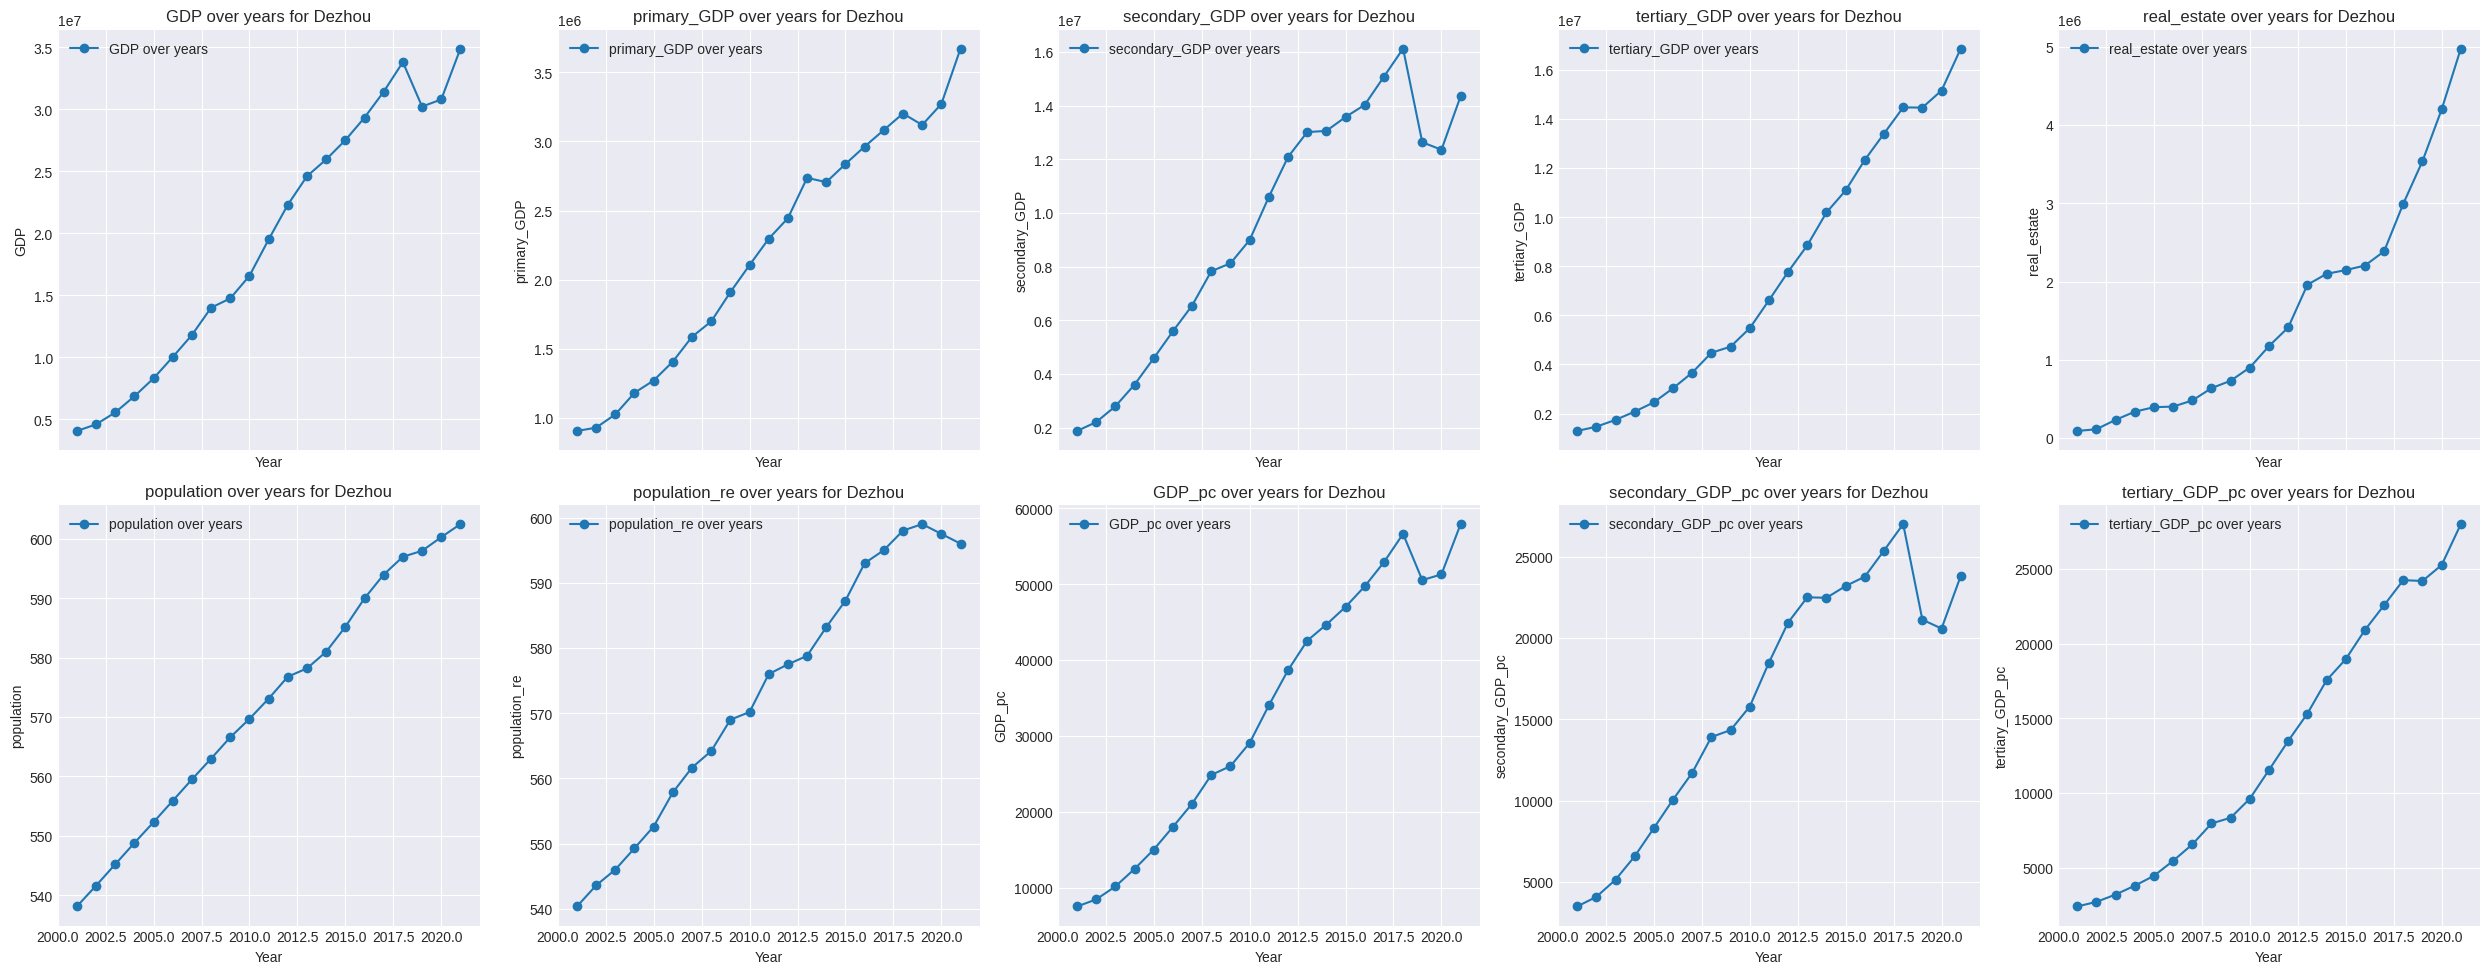

In [17]:
# Select a city from the treatment group in Shandong Province (DID group 1)
plot_indicators(filtered_data, 'Dezhou', indicator_columns, 2, 5)

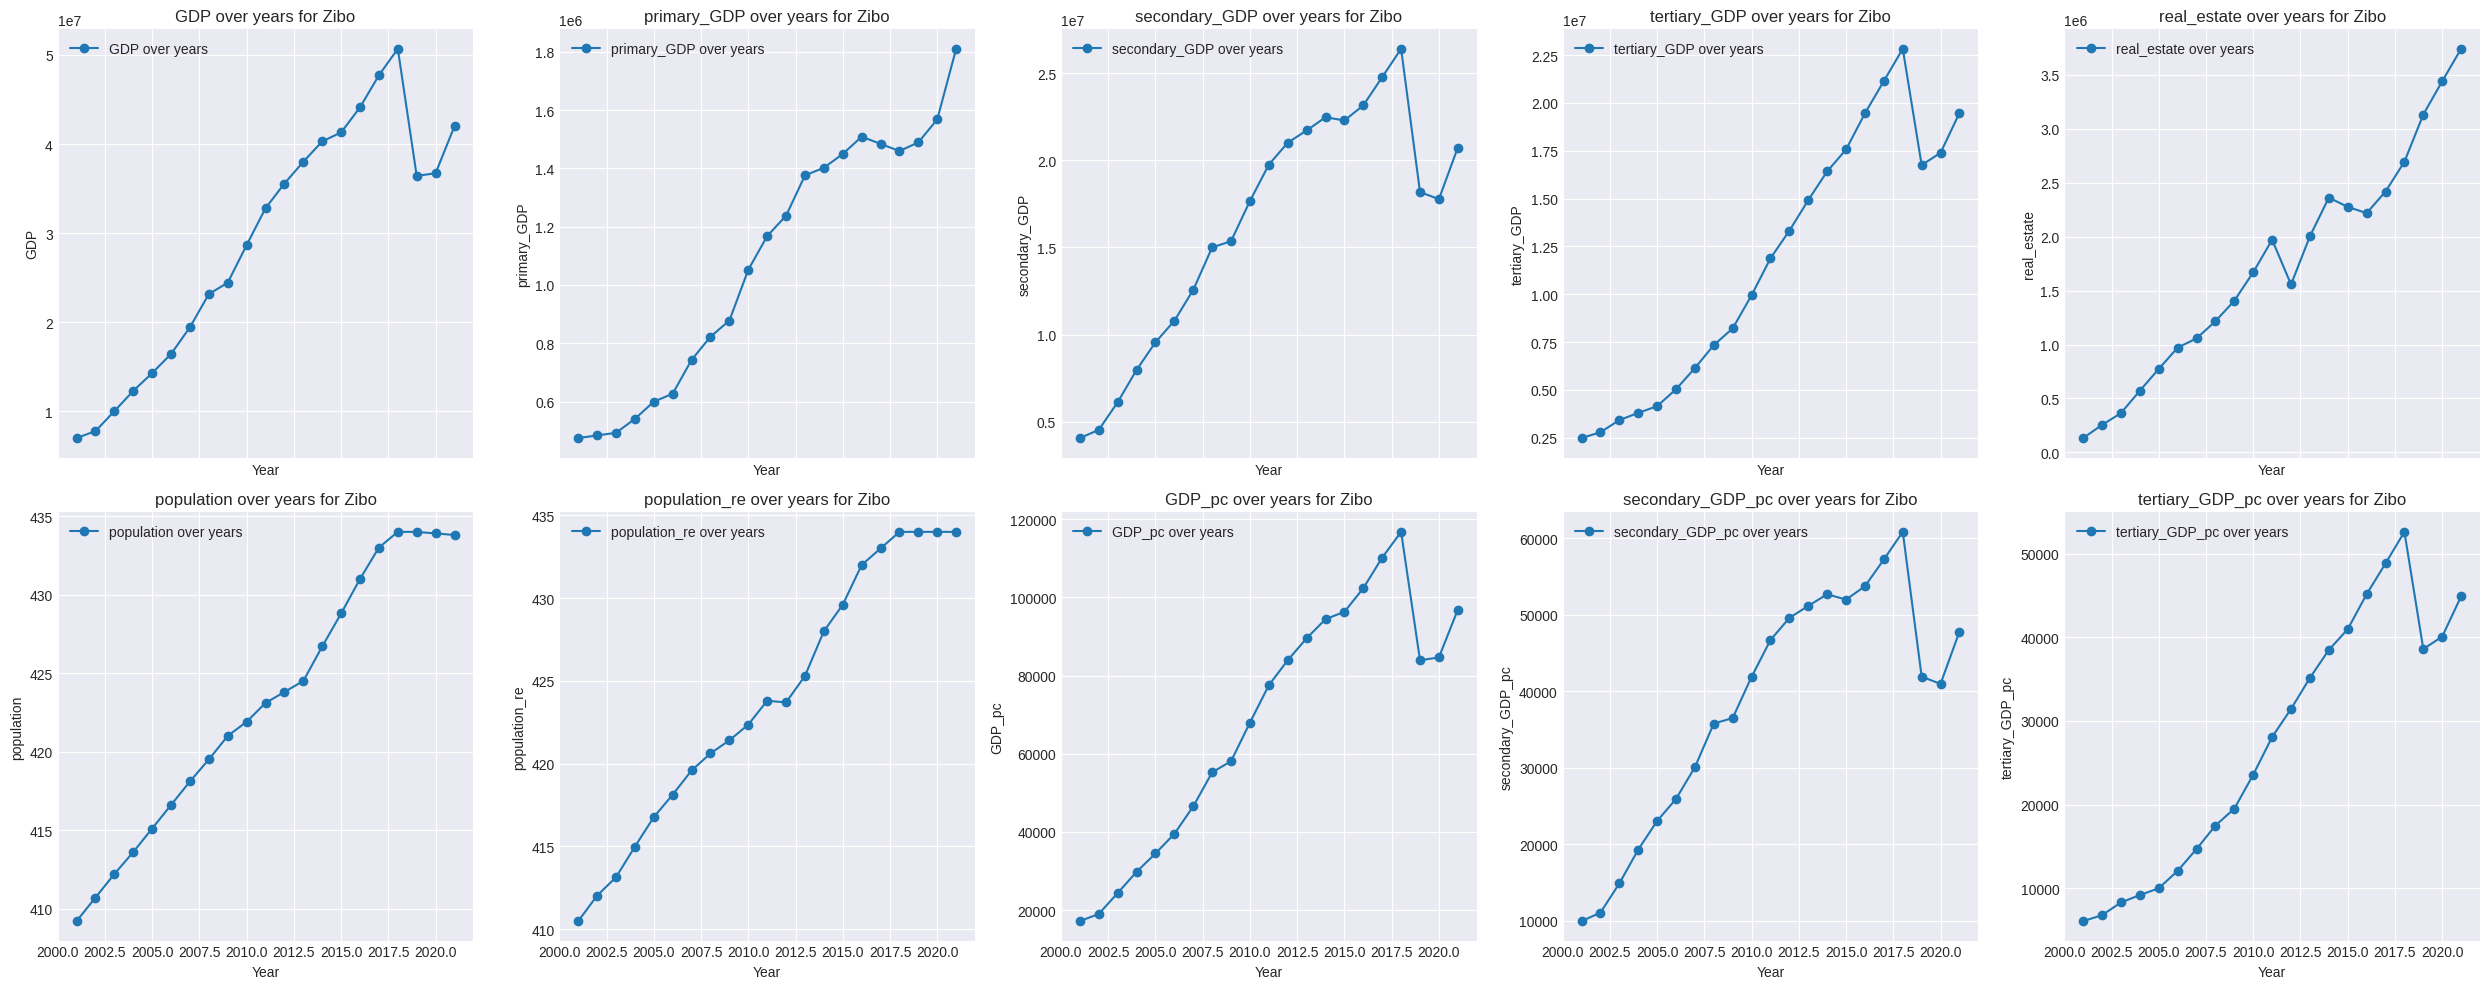

In [18]:
# Select a city from the control group in Shandong Province (DID group 1)
plot_indicators(filtered_data, 'Zibo', indicator_columns, 2, 5)

There's a significant problem that arises in the post-2019 portion of the GDP-related data. According to government policy, Shandong Province launched a GDP "squeeze" in 2019. To solve the problem of GDP over-reporting, the calculation standard was changed. However, our cut-off time for Shandong Province is 2015, so it will not be affected.

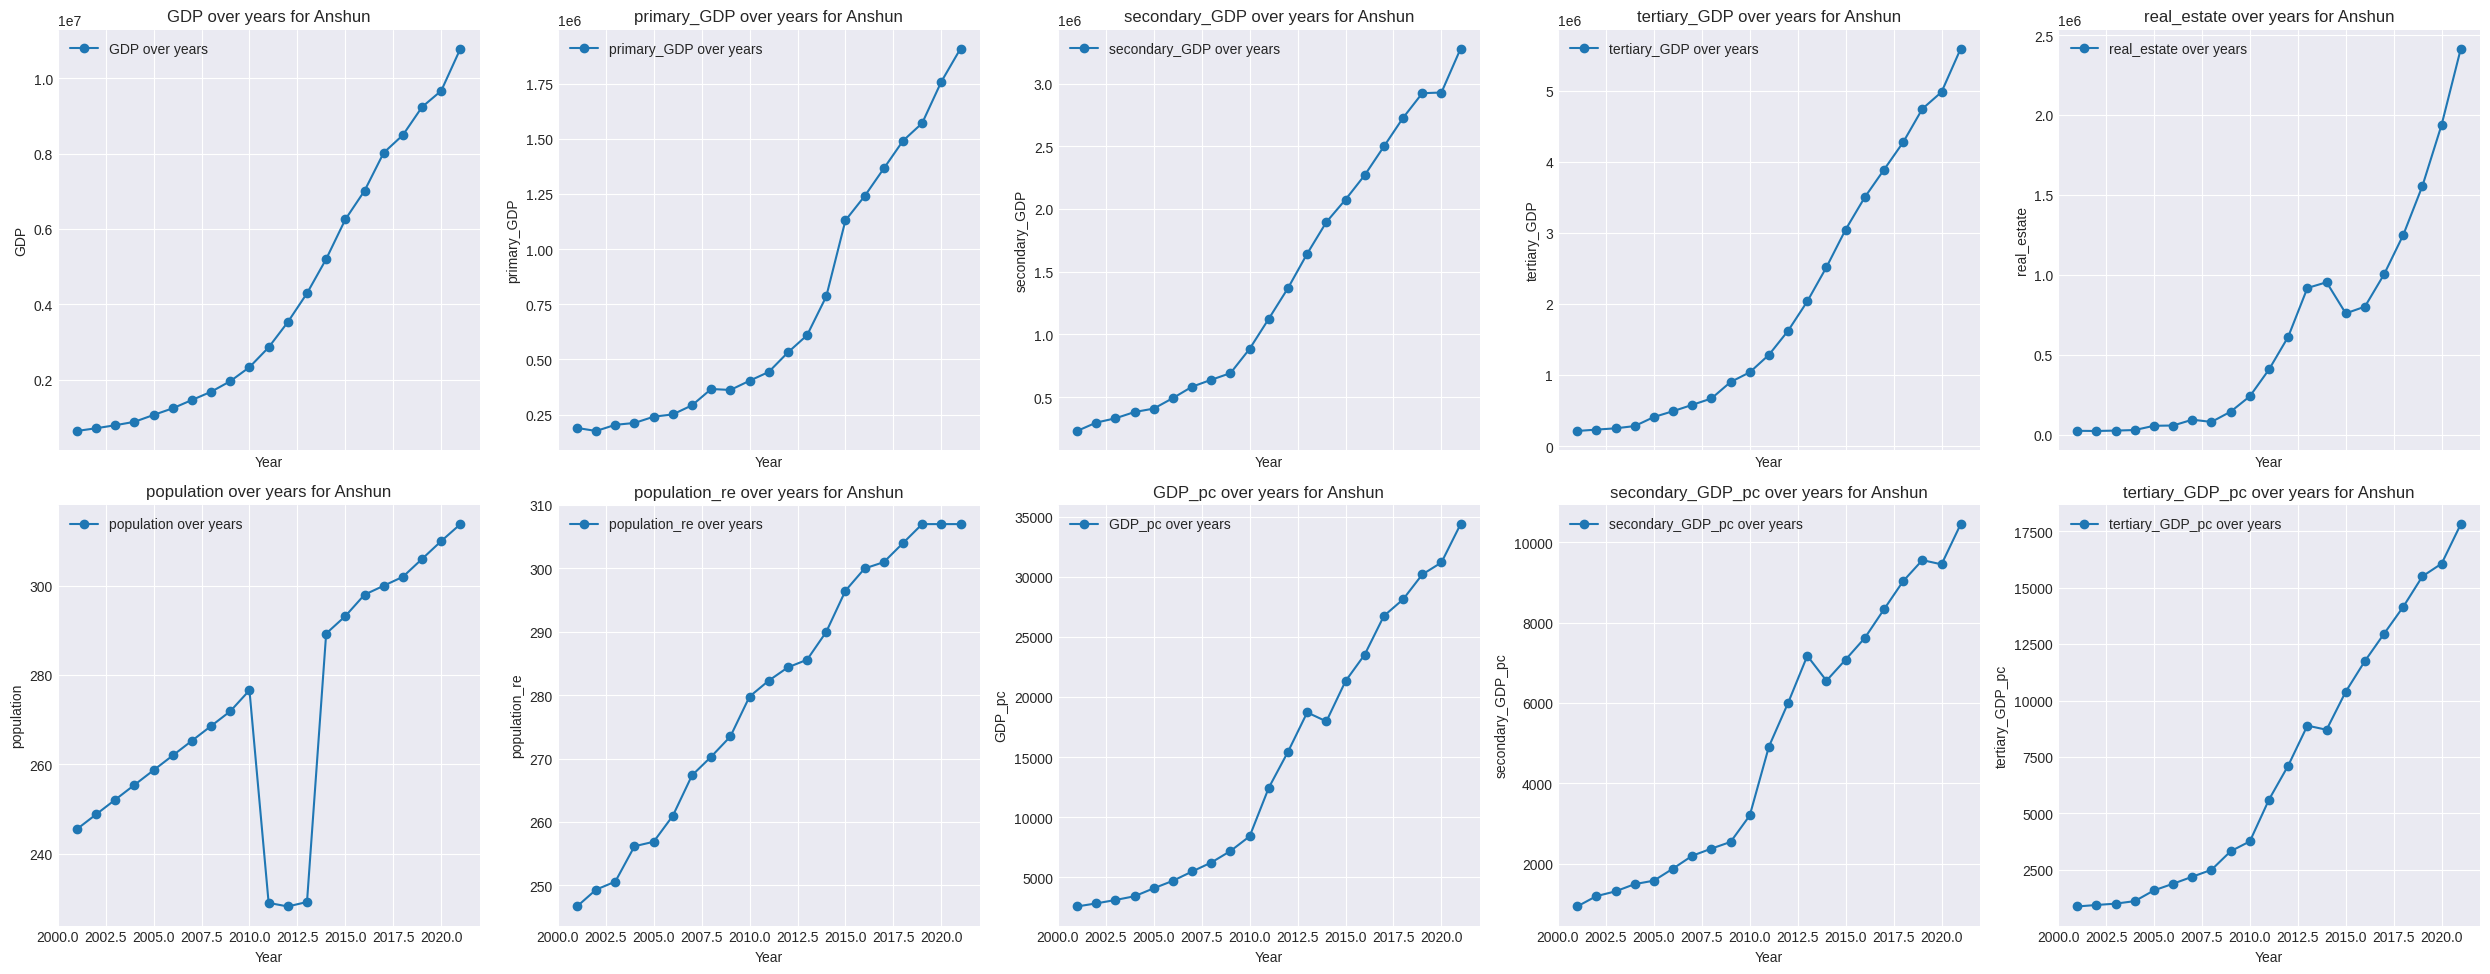

In [19]:
# Select a city from the treatment group in Guizhou Province (DID group 2)
plot_indicators(filtered_data, 'Anshun', indicator_columns, 2, 5)

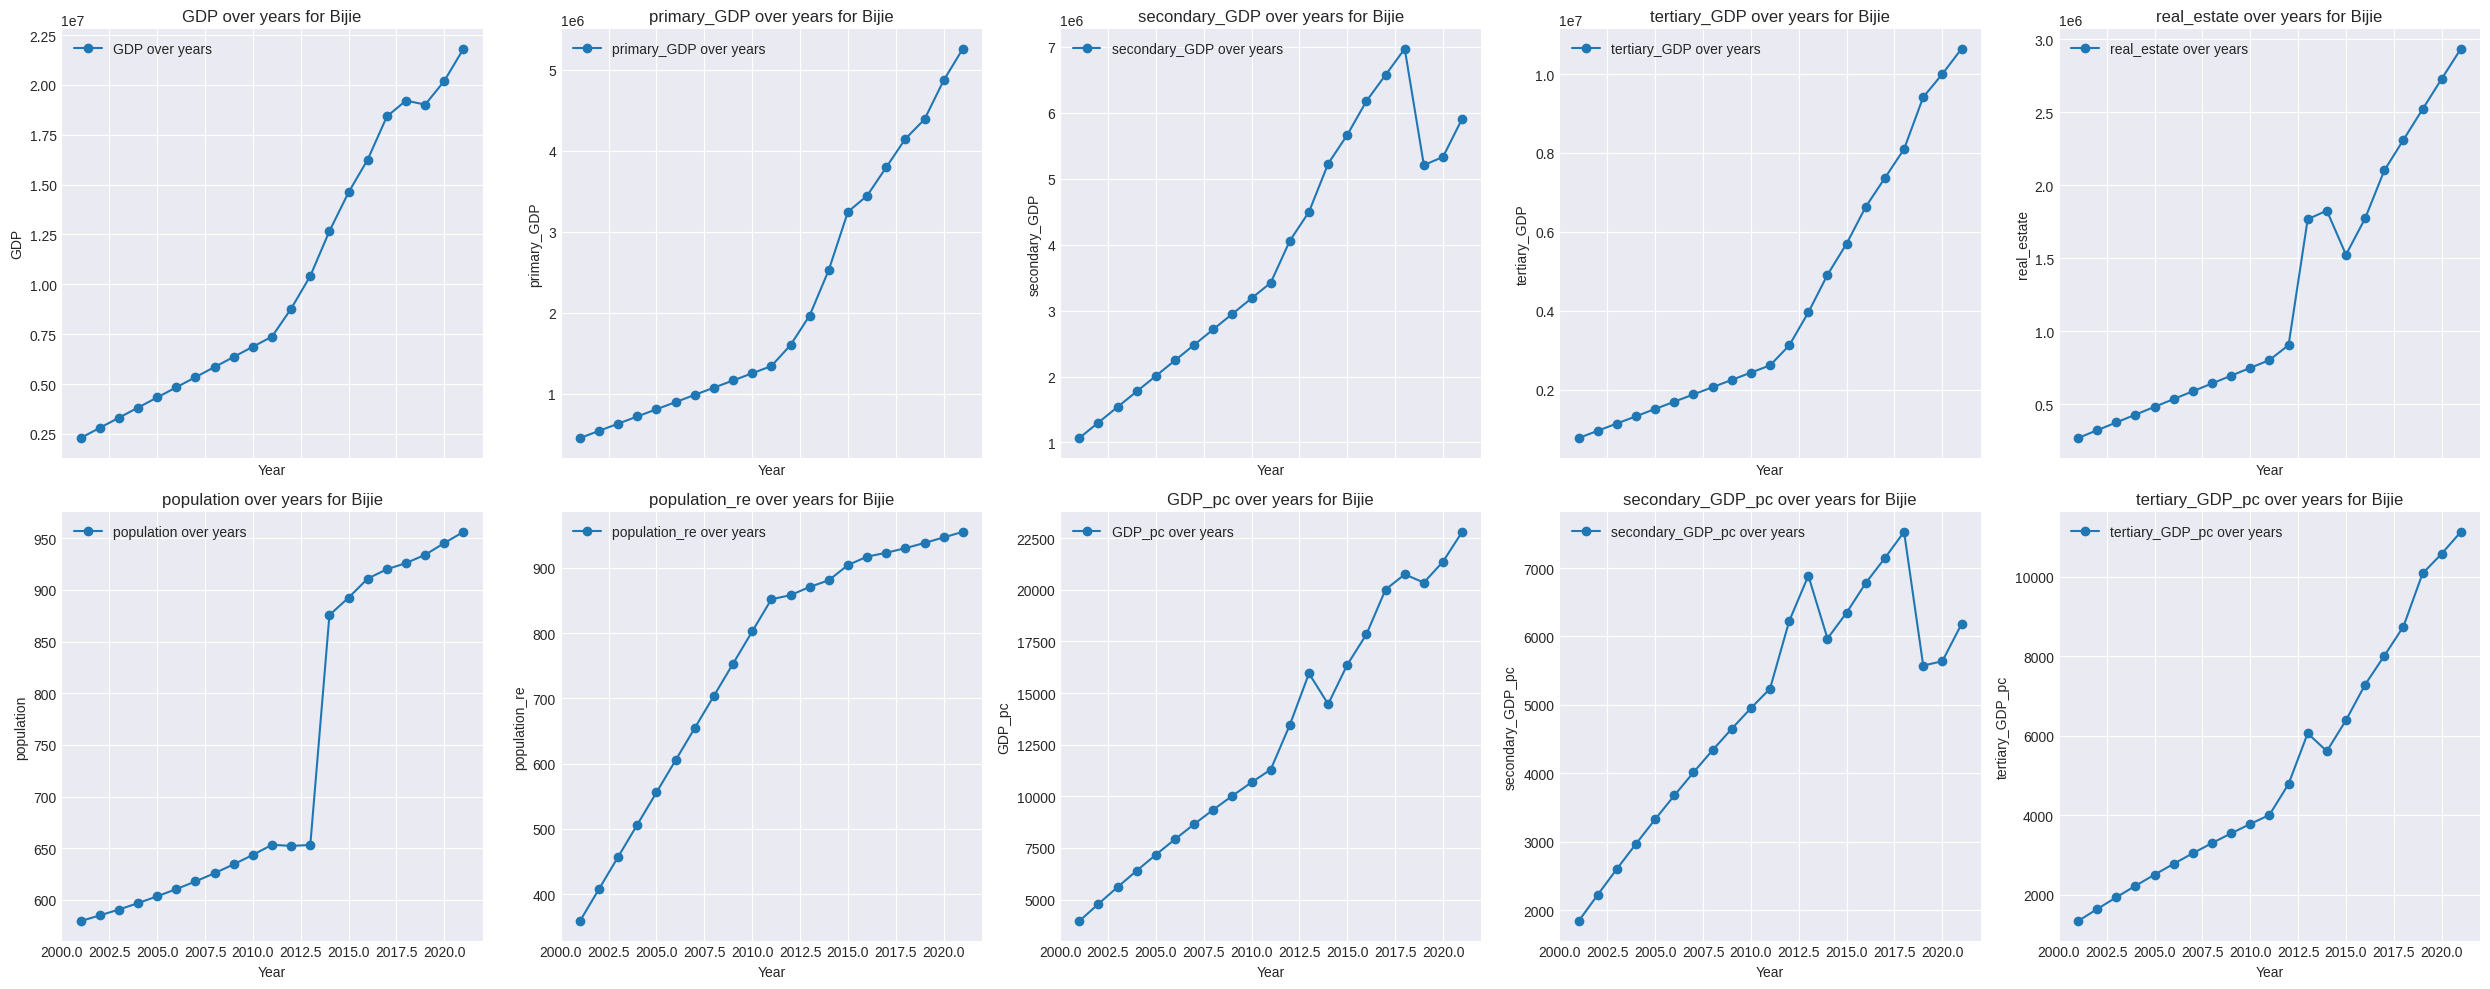

In [20]:
# Select a city from the control group in Guizhou Province (DID group 2)
plot_indicators(filtered_data, 'Bijie', indicator_columns, 2, 5)

In the process of checking the data of all cities, we found that the data of individual cities in individual years were abnormal. We manually queried government information to correct these data. After checking, these data are all real data, so we will not change them. Due to the anomalies in population data, we will not use per capita data. 

Regarding the impact of the COVID-19, Guizhou Province's GDP still had a positive growth rate in 2020 (4.5%) and 2021 (8.1%). Judging from the plot, there was no drastic change, so we retained the data for these two years.

Then, we can select the indicators to measure the impact in DID analysis, and take the logarithm of the necessary indicators. Due to data quality, we will not use all the filtered data.

In [21]:
# Take the logarithm of the GDP data we are going to use
indicator_log = ['GDP', 'secondary_GDP', 'tertiary_GDP', 'real_estate']

# Take the logarithm of the specified column and add a new column
for column in indicator_log:
    filtered_data[f'{column}_log'] = np.log(filtered_data[column])

filtered_data

year     city       GDP  primary_GDP  secondary_GDP  tertiary_GDP  \
0    2021     Zibo  42010000  1810631.000   2.073194e+07  1.947164e+07   
1    2020     Zibo  36730000  1568371.000   1.776997e+07  1.739166e+07   
2    2019     Zibo  36420000  1489578.000   1.818086e+07  1.674956e+07   
3    2018     Zibo  50683500  1459684.800   2.640104e+07  2.282785e+07   
4    2017     Zibo  47713600  1484296.110   2.477763e+07  2.114241e+07   
..    ...      ...       ...          ...            ...           ...   
268  2005  Tongren   2073252   601142.214   5.802114e+05  8.918959e+05   
269  2004  Tongren   1822602   528854.093   5.103967e+05  7.833478e+05   
270  2003  Tongren   1571952   456565.972   4.405820e+05  6.747997e+05   
271  2002  Tongren   1321301   384277.851   3.707674e+05  5.662516e+05   
272  2001  Tongren   1070651   311989.729   3.009527e+05  4.577034e+05   

     real_estate  population  population_re         GDP_pc  secondary_GDP_pc  \
0        3742557       433.8         434.00   96841.862609      47791.459198   
1        3441747       433.9         434.00   84650.841208      40954.076976   
2        3133055       434.0         434.00   83917.050691      41891.391705   
3        2694898       434.0         434.00  116782.258065      60831.878226   
4        2418498       433.0         433.00  110193.071594      57223.168176   
..           ...         ...            ...            ...               ...   
268       365059       305.7         268.46    6781.982336       1897.976369   
269       324747       285.8         242.00    6377.193842       1785.852715   
270       284435       266.0         215.55    5909.593985       1656.323447   
271       244123       246.2         189.09    5366.779041       1505.960065   
272       203811       226.4         162.63    4729.023852       1329.296369   

     tertiary_GDP_pc    GDP_log  secondary_GDP_log  tertiary_GDP_log  \
0       44886.203320  17.553418          16.847186         16.784469   
1       40082.173312  17.419104          16.693021         16.671501   
2       38593.451613  17.410629          16.715880         16.633882   
3       52598.729032  17.741111          17.088914         16.943492   
4       48827.728060  17.680727          17.025452         16.866791   
..               ...        ...                ...               ...   
268      2917.552902  14.544629          13.271148         13.701105   
269      2740.895024  14.415776          13.142944         13.571332   
270      2536.840880  14.267829          12.995852         13.422171   
271      2299.965678  14.094127          12.823330         13.246794   
272      2021.658242  13.883777          12.614708         13.033977   

     real_estate_log  
0          15.135280  
1          15.051490  
2          14.957519  
3          14.806871  
4          14.698657  
..               ...  
268        12.807814  
269        12.690802  
270        12.558260  
271        12.405427  
272        12.224948  

[273 rows x 16 columns]

In [22]:
# Indicators for DID analysis
indicator_DID = ['GDP_log', 'secondary_GDP_log', 'tertiary_GDP_log', 'real_estate_log']
indicator_DID

['GDP_log', 'secondary_GDP_log', 'tertiary_GDP_log', 'real_estate_log']

Finally, we can split the table into two groups for DID analysis, adjust the year range, and add the HSR opening variable.

In [23]:
# Extract the required columns
columns_to_extract = ['year', 'city'] + indicator_DID
filtered_data_final = filtered_data[columns_to_extract]

In [24]:
# Split the data of the first group of DID analysis (Shandong province)
cities_shandong = cities_shandong_treatment + cities_shandong_control
data_shandong = filtered_data_final[filtered_data_final['city'].isin(cities_shandong)]

# Keep the years required for analysis
data_shandong = data_shandong[data_shandong['year'].isin(list(range(2001, 2016)))]
data_shandong.reset_index(drop=True, inplace=True)

# Add the HSR opening variable
data_shandong['hsr'] = 0
mask = (data_shandong['year'].isin(years_shandong_post) & 
        data_shandong['city'].isin(cities_shandong_treatment))
data_shandong.loc[mask, 'hsr'] = 1

data_shandong

year  city    GDP_log  secondary_GDP_log  tertiary_GDP_log  \
0    2015  Zibo  17.536431          16.919504         16.681471   
1    2014  Zibo  17.511804          16.927870         16.614090   
2    2013  Zibo  17.453423          16.893407         16.518204   
3    2012  Zibo  17.387072          16.860625         16.404909   
4    2011  Zibo  17.306009          16.798844         16.290450   
..    ...   ...        ...                ...               ...   
115  2005  Heze  15.321475          14.477505         13.838670   
116  2004  Heze  15.110840          14.200532         13.606663   
117  2003  Heze  14.880566          13.848584         13.478142   
118  2002  Heze  14.731161          13.570248         13.322621   
119  2001  Heze  14.629636          13.351657         13.216997   

     real_estate_log  hsr  
0          14.638315    0  
1          14.675013    0  
2          14.510529    0  
3          14.258039    0  
4          14.494457    0  
..               ...  ...  
115        12.242419    0  
116        11.813297    0  
117        11.324473    0  
118        10.508159    0  
119        10.055436    0  

[120 rows x 7 columns]

In [25]:
# Split the data of the second group of DID analysis (Guizhou province)
cities_guizhou = cities_guizhou_treatment + cities_guizhou_control
data_guizhou = filtered_data_final[filtered_data_final['city'].isin(cities_guizhou)]

# Keep the years required for analysis
data_guizhou = data_guizhou[data_guizhou['year'].isin(list(range(2006, 2022)))]
data_guizhou.reset_index(drop=True, inplace=True)

# Add the HSR opening variable
data_guizhou['hsr'] = 0
mask = (data_guizhou['year'].isin(years_guizhou_post) & 
        data_guizhou['city'].isin(cities_guizhou_treatment))
data_guizhou.loc[mask, 'hsr'] = 1

data_guizhou

year        city    GDP_log  secondary_GDP_log  tertiary_GDP_log  \
0   2021  Liupanshui  16.506075          15.717518         15.646401   
1   2020  Liupanshui  16.410765          15.607357         15.554158   
2   2019  Liupanshui  16.353958          15.577647         15.480966   
3   2018  Liupanshui  16.540542          15.819613         15.665154   
4   2017  Liupanshui  16.497703          15.762810         15.576805   
..   ...         ...        ...                ...               ...   
75  2010     Tongren  15.017433          13.742170         14.176422   
76  2009     Tongren  14.939093          13.664071         14.097744   
77  2008     Tongren  14.854091          13.579352         14.012343   
78  2007     Tongren  14.761186          13.486785         13.918962   
79  2006     Tongren  14.658759          13.384768         13.815955   

    real_estate_log  hsr  
0         13.657505    0  
1         13.657664    0  
2         13.656293    0  
3         13.668088    0  
4         13.566571    0  
..              ...  ...  
75        13.247442    0  
76        13.173640    0  
77        13.093954    0  
78        13.007363    0  
79        12.912558    0  

[80 rows x 7 columns]

These are the final data used for analysis.

## 5 Methodology

### 5.1 Method Overview

The core idea is to use Fixed-effects-DID to analyze the impact of HSR opening in Shandong Province and Guizhou Province respectively, and then compare the two impacts. The process is as follows:

1. Conduct parallel trends test for Shandong Province data.
2. Based on the results, conduct Fixed-effects-DID analysis.
3. Apply the same procedure to Guizhou Province.
4. Compare the results of the two groups and draw conclusions.

The standard DID model is as follows:

$$
Y_{it} = \beta_0 + \beta_1 treat_{i} + \beta_2 period_{t} + \beta_3 treat_{i} \times period_{t} + \varepsilon_{it}
$$

The Fixed-effects-DID model is DID combined with the fixed effect model to better handle panel data:

$$
Y_{it} = \beta_0 + \beta_1 treat_{i} \times period_{t} + \lambda_{i} + \nu_{t} + \varepsilon_{it}
$$

Here, $\lambda_{i}$ is the individual fixed effect, which replaces the original treatment grouping variable.

$\nu_{t}$ is the time fixed effect, which replaces the original treatment time variable.

### 5.2 Fixed-effects-DID analysis for Shandong

#### 5.2.1 Parallel Trends Test

In [26]:
# Function for comparing the average trends of two sets of data
def plot_average_trends_subplot(data, column, treatment_cities, hsr_start_year, ax):
    
    # Distinguish between treatment and control groups
    data['treatment'] = data['city'].isin(treatment_cities).astype(int)

    # Calculate the mean value for each group in each year
    average_trends = data.groupby(['year', 'treatment'])[column].mean().unstack()

    ax.plot(average_trends.index, average_trends[0], label='Control Group')
    ax.plot(average_trends.index, average_trends[1], label='Treatment Group')
    ax.axvline(x=hsr_start_year, color='grey', linestyle='--', linewidth=2, label=f'HSR Start ({hsr_start_year})')
    ax.set_title(f'{column} by Year for Treatment and Control Groups')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Average of {column}')
    ax.legend()
    ax.grid(True)

In [27]:
# Function for comparing data trends of all cities
def plot_city_trends_subplot(data, column, treatment_cities, control_cities, hsr_start_year, ax):
    
    grouped = data.groupby(['year', 'city'])[column].mean().reset_index()

    # Draw a trend line for each city
    for city in treatment_cities:
        city_data = grouped[grouped['city'] == city]
        ax.plot(city_data['year'], city_data[column], marker='o', label=f'Treatment - {city}')

    for city in control_cities:
        city_data = grouped[grouped['city'] == city]
        ax.plot(city_data['year'], city_data[column], marker='s', linestyle='--', label=f'Control - {city}')

    # Add a vertical dashed line at the specified year
    ax.axvline(x=hsr_start_year, color='grey', linestyle='--', linewidth=2, label=f'HSR Start ({hsr_start_year})')
    
    ax.set_title(f'Yearly Trends in {column} by City')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Average of {column}')
    ax.grid(True)
    ax.legend(title='City Groups', bbox_to_anchor=(1.1, 0), loc='lower right')

In [28]:
def plot_all(data, treatment_cities, control_cities, hsr_start_year):
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    
    indicator_DID = ['GDP_log', 'secondary_GDP_log', 'tertiary_GDP_log', 'real_estate_log']
    
    # average trends
    for i, column in enumerate(indicator_DID):
        plot_average_trends_subplot(data_shandong, column, cities_shandong_treatment, 2011, axs[0, i])

    # trends of all cities
    for i, column in enumerate(indicator_DID):
        plot_city_trends_subplot(data_shandong, column, cities_shandong_treatment, cities_shandong_control, 2011, axs[1, i])
    
    plt.tight_layout()
    plt.show()

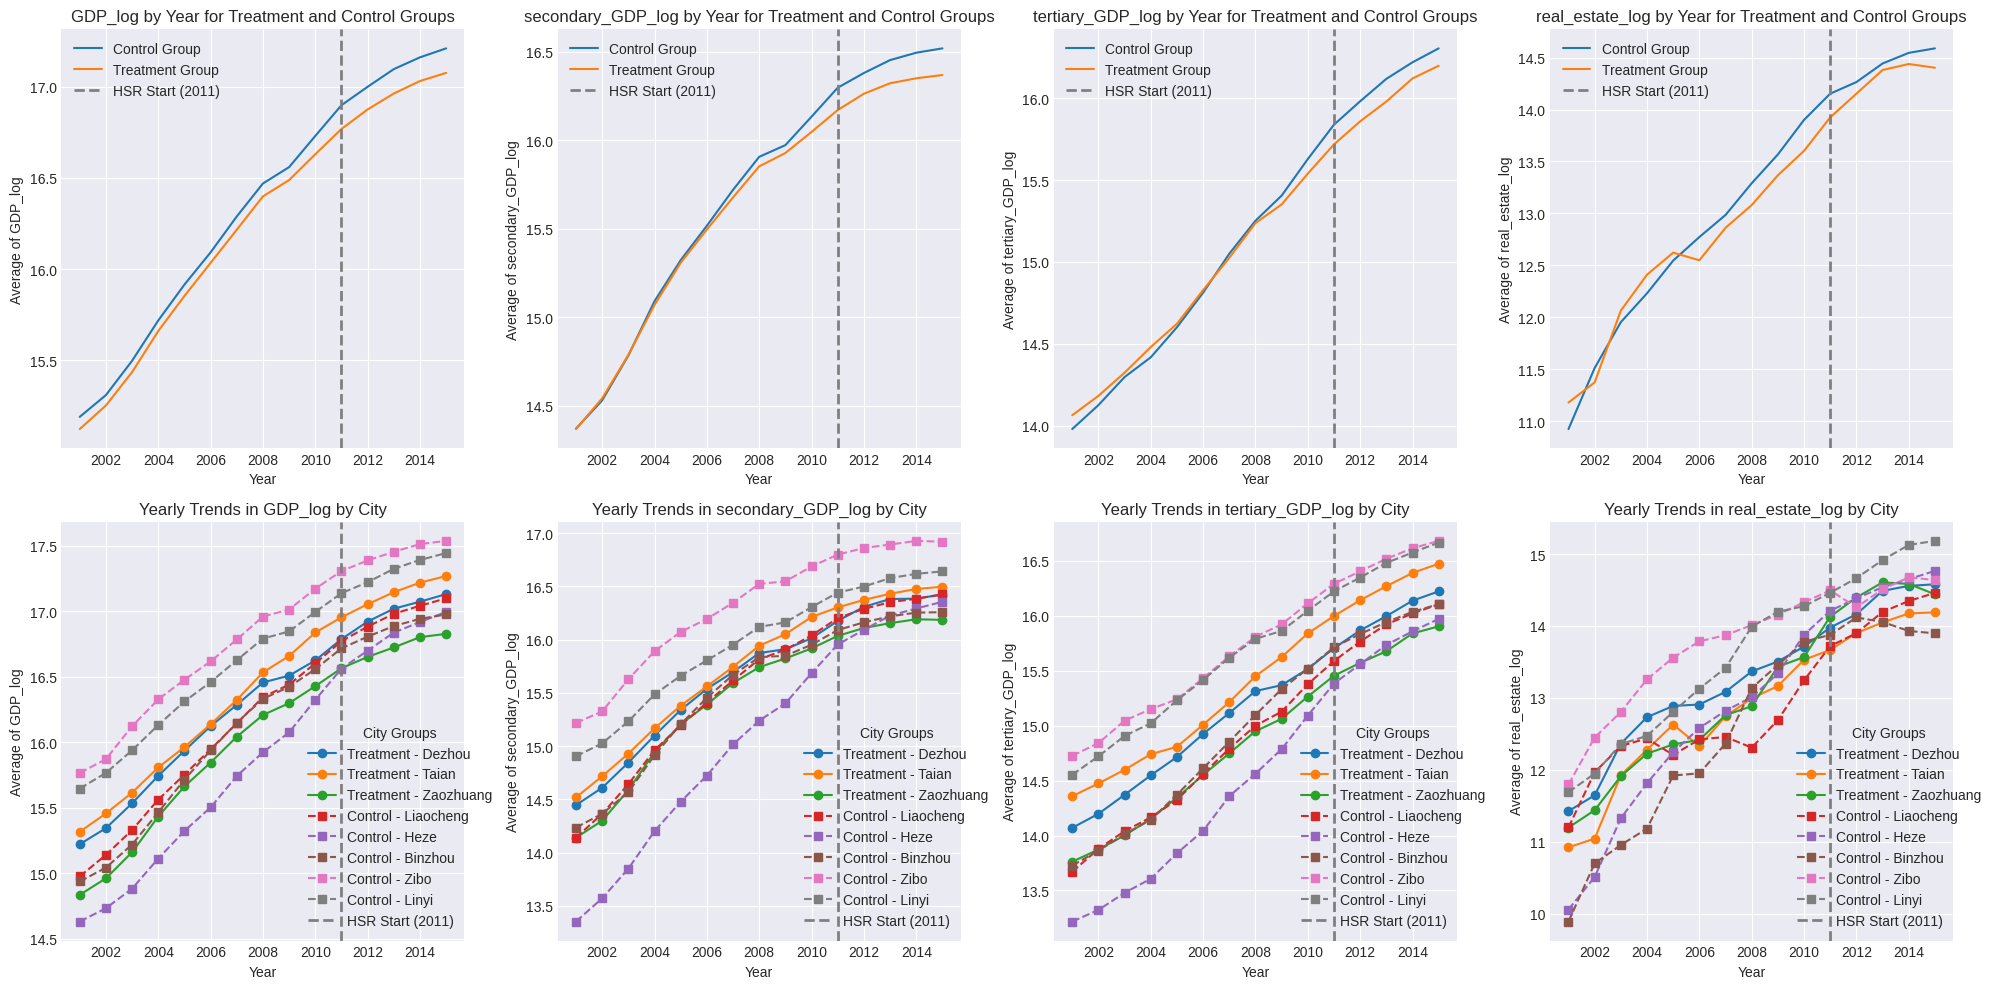

In [29]:
plot_all(data_shandong, cities_shandong_treatment, cities_shandong_control, 2011)

#### 5.2.2 DID analysis

In [30]:
# Functions used to fit the model
def run_fixed_effects_model(data_pro, treatment_cities, post_hsr_years, response_variable, hsr_start_year):

    data = data_pro.copy()
    
    # Create treatment and control group markers
    data['treatment'] = data['city'].isin(treatment_cities).astype(int)

    # Create time period markers before and after the high-speed rail opening
    data['post'] = data['year'].isin(post_hsr_years).astype(int)

    # Creating interaction terms
    data['treatment_post'] = data['treatment'] * data['post']

    # Convert the city column into a categorical variable
    data['city'] = data['city'].astype('category')

    # Year as a continuous variable
    data['t'] = data['year'].astype(int) - hsr_start_year

    # Construct a fixed effect model formula and add fixed effects of city and year
    model_formula = f'{response_variable} ~ treatment_post + C(city) + C(t)'

    # Fitting the model
    model = smf.ols(model_formula, data=data).fit()

    # Output model results
    print(model.summary())

    return model

In [31]:
# Functions for printing and storing results
def model_results(fixed_effects_model, data_pro, treatment_cities, post_hsr_years, hsr_start_year):
    
    # Indicators to use for analysis
    indicator_DID = ['GDP_log', 'secondary_GDP_log', 'tertiary_GDP_log', 'real_estate_log']
    
    # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=['Response Variable', 'Coefficient', 'Std Error', 
                                       't-value', 'P-value', 'Conf. Int. Low', 'Conf. Int. High'])
    
    # Fit the model
    for response_variable in indicator_DID:
        print('//////////////////////////////////////////////////////////////////////////////////////')
        print(f'{response_variable}')
        print('//////////////////////////////////////////////////////////////////////////////////////')
        model = fixed_effects_model(data_pro, treatment_cities, post_hsr_years, response_variable, hsr_start_year)
        print(' ')
        print(' ')
        print(' ')
        
        # Extracting model results
        conf_int = model.conf_int()
        
        # Add the desired results to the DataFrame
        temp_df = pd.DataFrame({
            'Response Variable': [response_variable],
            'Coefficient': [model.params['treatment_post']],
            'Std Error': [model.bse['treatment_post']],
            't-value': [model.tvalues['treatment_post']],
            'P-value': [model.pvalues['treatment_post']],
            'Conf. Int. Low': [conf_int.loc['treatment_post', 0]],
            'Conf. Int. High': [conf_int.loc['treatment_post', 1]]
        })
    
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

    return results_df

In [32]:
# Get results for Shandong Province
results_shandong = model_results(run_fixed_effects_model, data_shandong, cities_shandong_treatment, years_shandong_post, 2011)

//////////////////////////////////////////////////////////////////////////////////////
GDP_log
//////////////////////////////////////////////////////////////////////////////////////
                            OLS Regression Results                            
Dep. Variable:                GDP_log   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     421.1
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           2.89e-86
Time:                        01:15:51   Log-Likelihood:                 142.46
No. Observations:                 120   AIC:                            -238.9
Df Residuals:                      97   BIC:                            -174.8
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                           c

It can be found from the results that R-Squared is very high. Considering that adding time fixed effects significantly increases the number of parameters, there may be a risk of overfitting.

To solve the problem, we adjust the model to treat time as a continuous variable and assume that the logarithm of GDP and other related indicators grows linearly over time. A simplified model is used for analysis.

In [33]:
# Functions used to fit the simplified model
def run_fixed_effects_model_simplified(data_pro, treatment_cities, post_hsr_years, response_variable, hsr_start_year):

    data = data_pro.copy()
    
    # Create treatment and control group markers
    data['treatment'] = data['city'].isin(treatment_cities).astype(int)

    # Create time period markers before and after the high-speed rail opening
    data['post'] = data['year'].isin(post_hsr_years).astype(int)

    # Creating interaction terms
    data['treatment_post'] = data['treatment'] * data['post']

    # Convert the city column into a categorical variable
    data['city'] = data['city'].astype('category')

    # Year as a continuous variable
    data['t'] = data['year'].astype(int) - hsr_start_year

    # Construct a fixed effect model formula and add fixed effects of city and year
    model_formula = f'{response_variable} ~ treatment_post + C(city) + t'

    # Fitting the model
    model = smf.ols(model_formula, data=data).fit()

    # Output model results
    print(model.summary())

    return model

In [34]:
# Get the results for Shandong Province for the simplified model
results_shandong_simplified = model_results(run_fixed_effects_model_simplified, data_shandong, cities_shandong_treatment, years_shandong_post,  2011)

//////////////////////////////////////////////////////////////////////////////////////
GDP_log
//////////////////////////////////////////////////////////////////////////////////////
                            OLS Regression Results                            
Dep. Variable:                GDP_log   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     458.2
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           7.17e-83
Time:                        01:15:51   Log-Likelihood:                 87.300
No. Observations:                 120   AIC:                            -154.6
Df Residuals:                     110   BIC:                            -126.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           c

The R-square of the simplified model is still high, and the results of the "treatment_post" items we are concerned about are basically consistent with the former model. Then, the same analysis process is carried out for Guizhou Province.

### 5.3 Fixed-effects-DID analysis for Guizhou

#### 5.3.1 Parallel Trends Test

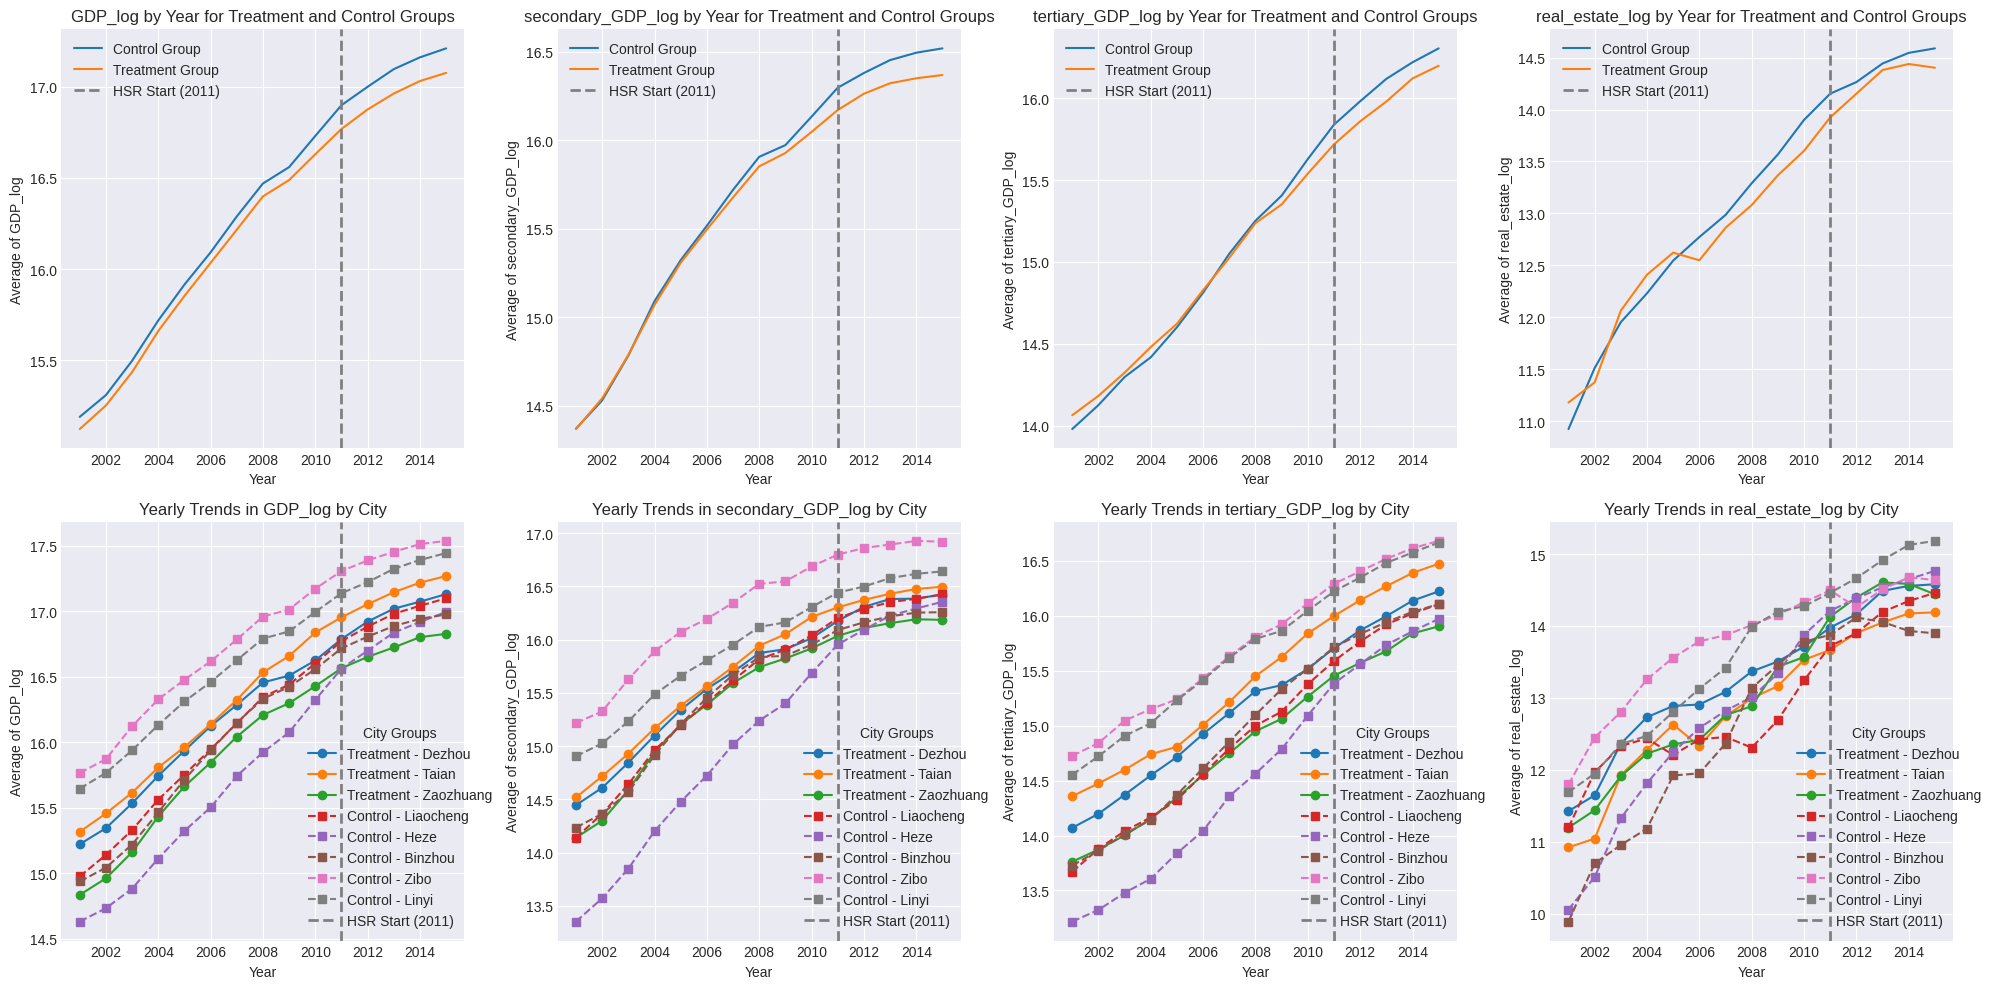

In [35]:
plot_all(data_guizhou, cities_guizhou_treatment, cities_guizhou_control, 2011)

#### 5.3.2 DID analysis

In [36]:
# Get results for Guizhou Province
results_guizhou = model_results(run_fixed_effects_model, data_guizhou, cities_guizhou_treatment, years_guizhou_post, 2017)

//////////////////////////////////////////////////////////////////////////////////////
GDP_log
//////////////////////////////////////////////////////////////////////////////////////
                            OLS Regression Results                            
Dep. Variable:                GDP_log   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     214.4
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           1.36e-47
Time:                        01:15:53   Log-Likelihood:                 78.208
No. Observations:                  80   AIC:                            -114.4
Df Residuals:                      59   BIC:                            -64.39
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            

In [37]:
# Get results for Guizhou Province for the simplified model
results_guizhou_simplified = model_results(run_fixed_effects_model_simplified, data_guizhou, cities_guizhou_treatment, years_guizhou_post, 2017)

//////////////////////////////////////////////////////////////////////////////////////
GDP_log
//////////////////////////////////////////////////////////////////////////////////////
                            OLS Regression Results                            
Dep. Variable:                GDP_log   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     410.6
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           3.91e-54
Time:                        01:15:54   Log-Likelihood:                 48.145
No. Observations:                  80   AIC:                            -82.29
Df Residuals:                      73   BIC:                            -65.62
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            

## 6 Results

### 6.1 Results display

Here, we list all the results corresponding to the "treatment_post" item for comparison.

In [38]:
# Results of Shandong province
results_shandong

Response Variable  Coefficient  Std Error   t-value   P-value  \
0            GDP_log    -0.062684   0.032842 -1.908623  0.059267   
1  secondary_GDP_log    -0.106793   0.058716 -1.818824  0.072024   
2   tertiary_GDP_log    -0.125935   0.041832 -3.010518  0.003324   
3    real_estate_log    -0.082191   0.128173 -0.641252  0.522871   

   Conf. Int. Low  Conf. Int. High  
0       -0.127867         0.002499  
1       -0.223328         0.009741  
2       -0.208960        -0.042911  
3       -0.336579         0.172196

In [39]:
# Results of Shandong province (simplified model)
results_shandong_simplified

Response Variable  Coefficient  Std Error   t-value   P-value  \
0            GDP_log    -0.128755   0.044617 -2.885768  0.004700   
1  secondary_GDP_log    -0.235012   0.076132 -3.086915  0.002560   
2   tertiary_GDP_log    -0.109188   0.041957 -2.602362  0.010534   
3    real_estate_log    -0.162275   0.128540 -1.262448  0.209457   

   Conf. Int. Low  Conf. Int. High  
0       -0.217175        -0.040334  
1       -0.385887        -0.084137  
2       -0.192338        -0.026039  
3       -0.417010         0.092461

In [40]:
# Results of Guizhou province
results_guizhou

Response Variable  Coefficient  Std Error   t-value   P-value  \
0            GDP_log     0.159980   0.052192  3.065211  0.003278   
1  secondary_GDP_log     0.227448   0.079591  2.857691  0.005887   
2   tertiary_GDP_log     0.135689   0.055533  2.443383  0.017561   
3    real_estate_log     0.043796   0.176528  0.248096  0.804922   

   Conf. Int. Low  Conf. Int. High  
0        0.055544         0.264415  
1        0.068186         0.386710  
2        0.024567         0.246810  
3       -0.309436         0.397028

In [41]:
# Results of Guizhou province (simplified model)
results_guizhou_simplified

Response Variable  Coefficient  Std Error   t-value   P-value  \
0            GDP_log     0.046134   0.061473  0.750473  0.455382   
1  secondary_GDP_log     0.065459   0.087292  0.749886  0.455733   
2   tertiary_GDP_log     0.031689   0.061477  0.515462  0.607788   
3    real_estate_log    -0.183399   0.168946 -1.085549  0.281250   

   Conf. Int. Low  Conf. Int. High  
0       -0.076382         0.168650  
1       -0.108513         0.239432  
2       -0.090835         0.154213  
3       -0.520107         0.153309

### 6.2 Interpretation

First, let’s compare the performance of the two models within their respective groups. 

- In the Shandong Province group, both models performed well and the results tended to be consistent.

- In the Guizhou Province group, the two models are quite different. The "treatment_post" item we care about is not significant for all indicators in the simplified model. We were unable to identify the effect, which may be due to the linear treatment in the simplified model masking its effect.

We can then compare the results of the two sets of analyses. 

- For Shandong Province, which is the economically developed region where HSR was built earlier, the coefficients of the four indicators in both models are negative, indicating that the opening of the HSR has brought negative impacts.

- For Guizhou Province, the estimated effects of the two models are positive and insignificant respectively. It shows that the opening of HSR will at least have no negative impact.

## 7 Discussion and conclusion

In conclusion, the role of high-speed rail in promoting underdeveloped regions is greater than that in developed regions. This is contrary to the view that newly built HSR has lower promotion effects. However, it is not reflected in the different degree of promotion, but because the role of HSR in Shandong area is negative.

This counterintuitive conclusion has also appeared in other studies. A study on residents' income showed that HSR had a positive or no impact in the Midwest and a negative impact in the East (Jin et al., 2022). The reason behind this may be that the siphon effect brought by HSR is greater than the diffusion effect (Wang et al., 2022). The two ends of Shandong Province's HSR are Beijing and Shanghai, which may make its economic population more easily transferred and lost.

In addition, we can find that the coefficients of the secondary industry is the largest. People generally believe that HSR has a closer relationship with the tertiary industry because of tourism. However, studies have shown that the HSR network has accelerated the transfer of low-end manufacturing companies to less developed regions. In comparison, tourism is only a side effect. This may be the reason why the secondary industry has been more significantly affected.

Finally, although people generally believe that HSR will significantly promote real estate investment, the real-estate-related data we use is not suitable. This may be due to the low quality of the data. Limited by the data, this study failed to test more indicators such as GDP per capita. Future research can combine more reasonable new indicators to analyze a wider range.

## References

Chen, C.-L. and Hall, P. (2012) ‘The wider spatial-economic impacts of high-speed trains: a comparative case study of Manchester and Lille sub-regions’, Journal of Transport Geography, 24, pp. 89–110. Available at: https://doi.org/10.1016/j.jtrangeo.2011.09.002.

Chen, Z. et al. (2023) ‘The Influence of High-speed Rail on the Level and Structure of Urban Economic Vitality: An Empirical Study Based on Real GDP Data’, Applied Spatial Analysis and Policy [Preprint]. Available at: https://doi.org/10.1007/s12061-023-09554-7.

Chi, F. and Han, H. (2023) ‘The Impact of High-Speed Rail on Economic Development: A County-Level Analysis’, Land, 12(4), p. 874. Available at: https://doi.org/10.3390/land12040874.

China Statistical Yearbook 2023 (no date) Available at: https://www.stats.gov.cn/sj/ndsj/2023/indexeh.htm (Accessed: 29 April 2024).

DataV.GeoAtlas Geography Gadget Series (no date). Available at: https://datav.aliyun.com/portal/school/atlas/area_selector (Accessed: 29 April 2024).

Deng, T. et al. (2020) ‘Did high-speed railway cause urban space expansion? ——Empirical evidence from China’s prefecture-level cities’, Research in Transportation Economics, 80, p. 100840. Available at: https://doi.org/10.1016/j.retrec.2020.100840.

Fan, X. and Xu, Y. (2023) ‘Does high-speed railway promote urban innovation? Evidence from China’, Socio-Economic Planning Sciences, 86, p. 101464. Available at: https://doi.org/10.1016/j.seps.2022.101464.

Gis5g (no date) Statistical Yearbook – gis5g. (Chinese) Available at: http://www.gis5g.com/data/tjnj?id=267 (Accessed: 29 April 2024).

‘High-speed rail in China’ (2024) Wikipedia. Available at: https://en.wikipedia.org/w/index.php?title=High-speed_rail_in_China&oldid=1220267490 (Accessed: 29 April 2024).

Imai, K. and Kim, I.S. (2019) ‘When Should We Use Unit Fixed Effects Regression Models for Causal Inference with Longitudinal Data?’, American Journal of Political Science, 63(2), pp. 467–490. Available at: https://doi.org/10.1111/ajps.12417.

Jin, M. et al. (2022) ‘Heterogeneous impact of high speed railway on income distribution: A case study in China’, Socio-Economic Planning Sciences, 79, p. 101128. Available at: https://doi.org/10.1016/j.seps.2021.101128.

Ke, X. et al. (2017) ‘Do China’s high-speed-rail projects promote local economy?—New evidence from a panel data approach’, China Economic Review, 44, pp. 203–226. Available at: https://doi.org/10.1016/j.chieco.2017.02.008.

Liang, Y. et al. (2020) ‘Effectiveness of high-speed railway on regional economic growth for less developed areas’, Journal of Transport Geography, 82, p. 102621. Available at: https://doi.org/10.1016/j.jtrangeo.2019.102621.

Lin, Y. (2017) ‘Travel costs and urban specialization patterns: Evidence from China’s high speed railway system’, Journal of Urban Economics, 98, pp. 98–123. Available at: https://doi.org/10.1016/j.jue.2016.11.002.

Oakes, J.M. and Kaufman, J.S. (2017) Methods in Social Epidemiology. John Wiley & Sons.

Reichardt, A. et al. (2012) ‘Sustainable Building Certification and the Rent Premium: A Panel Data Approach’, Journal of Real Estate Research, 34(1), pp. 99–126. Available at: https://doi.org/10.1080/10835547.2012.12091325.

Wang, F. et al. (2022) ‘High-speed railway development and its impact on urban economy and population: A case study of nine provinces along the Yellow River, China’, Sustainable Cities and Society, 87, p. 104172. Available at: https://doi.org/10.1016/j.scs.2022.104172.